# Import libraries

In [1]:
import os
from google.colab import drive
drive.mount('/content/drive') # Uncomment when running the notebook for first time
os.chdir("/content/drive/MyDrive/SurgTools")
os.getcwd()

Mounted at /content/drive


'/content/drive/MyDrive/SurgTools'

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torchvision
from torchvision import transforms as T
from torchvision import utils
import xml.etree.ElementTree as ET
from PIL import Image
import cv2
import matplotlib.pyplot as plt
from torch.utils.data.dataloader import default_collate
from tqdm import tqdm
import numpy as np

# Code to preprocess data, visualize the images and the boxes

In [3]:
# Parse XML files
def parse_xml(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    objects = []
    for obj in root.iter('object'):
        obj_dict = {
            'name': obj.find('name').text,
            'bbox': [
                int(obj.find('bndbox/xmin').text),
                int(obj.find('bndbox/ymin').text),
                int(obj.find('bndbox/xmax').text),
                int(obj.find('bndbox/ymax').text)
            ]
        }
        objects.append(obj_dict)
    return objects

In [ ]:
parse_xml("./m2cai16-tool-locations/Annotations/v01_002075.xml")

[{'name': 'Grasper', 'bbox': [201, 171, 256, 191]}]

In [4]:
# Visual bounding boxes
def visualize_image(image_path, objects):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # OpenCV uses BGR by default
    for obj in objects:
        bbox = obj['bbox']
        cv2.rectangle(image, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 255, 0), 2)
        cv2.putText(image, obj['name'], (bbox[0], bbox[1]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
    plt.imshow(image)
    plt.show()


def visualize_image_2(image, objects):
  for obj in objects:
        obj['boxes'] = [int(i) for i in obj['boxes']]
        bbox = obj['boxes']
        cv2.rectangle(image, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 255, 0), 2)
        cv2.putText(image, obj['labels'], (bbox[0], bbox[1]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
  plt.imshow(image)
  plt.show()

# visualize_image("./m2cai16-tool-locations/JPEGImages/v01_002075.jpg", parse_xml("./m2cai16-tool-locations/Annotations/v01_002075.xml"))

In [5]:
your_label_map = {
    "Grasper": 1,
    "Bipolar": 2,
    "Hook": 3,
    "Scissors": 4,
    "Clipper": 5,
    "Irrigator": 6,
    "SpecimenBag": 7
}


def resize_bbox(bbox, in_size, out_size):
    """
    Adjust bounding box size.
    :param bbox: Original bounding box coordinates in the format [xmin, ymin, xmax, ymax]
    :param in_size: original image size (width, height)
    :param out_size: new image size (width, height)
    :return: adjusted bounding box coordinates
    """
    xmin, ymin, xmax, ymax = bbox
    scale_x = out_size[0] / in_size[0]
    scale_y = out_size[1] / in_size[1]
    xmin = int(xmin * scale_x)
    ymin = int(ymin * scale_y)
    xmax = int(xmax * scale_x)
    ymax = int(ymax * scale_y)
    return [xmin, ymin, xmax, ymax]


class CustomDataset(Dataset):
    def __init__(self, imgs_dir, anns_dir, transforms=None):
        self.imgs_dir = imgs_dir
        self.anns_dir = anns_dir
        self.transforms = transforms

        # Get the names of all image and annotation files, with extensions removed
        anns = set(os.path.splitext(file)[0] for file in os.listdir(anns_dir))
        imgs = anns

        # Keep image file names with matching annotations
        self.imgs = [file + '.jpg' for file in imgs]  # Assuming the image file is in .jpg format
        self.annotations = [file + '.xml' for file in anns]  # Assume that the annotation file is in .xml format

        # Make sure the image and annotation file lists are of equal length
        assert len(self.imgs) == len(self.annotations), "Images and annotations lists are not the same length"

    def __getitem__(self, idx):
        # print("getting")
        img_path = os.path.join(self.imgs_dir, self.imgs[idx])
        ann_path = os.path.join(self.anns_dir, self.annotations[idx])

        # read images
        image = Image.open(img_path).convert("RGB")
        original_size = image.size
        new_size = (600, 600)

        # Parse XML files using parse_xml function
        objects = parse_xml(ann_path)


        boxes = []
        labels = []
        num_objs = len(objects)
        for obj in objects:
            label_name = obj['name']
            label = your_label_map[label_name]  # Convert category name to integer
            labels.append(label)

            # Add bounding box coordinates
            bbox = obj['bbox']
            resized_bbox = resize_bbox(bbox, original_size, new_size)
            boxes.append(resized_bbox)

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)


        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        # target["image_id"] = idx
        # target["area"] = area
        # target["iscrowd"] = iscrowd

        if self.transforms is not None:
            image = self.transforms(image)  # Apply conversion to image
            # If necessary, you can also convert the target accordingly
            # For example, if random flipping is used, the bounding box of the target needs to be adjusted accordingly

        return image, target

    def __len__(self):
        return len(self.imgs)


In [6]:
from torchvision.transforms import functional as F


# imgs_dir = "/content/m2cai16-tool-locations/JPEGImages"
# anns_dir = "/content/m2cai16-tool-locations/Annotations"

imgs_dir = "./m2cai16-tool-locations/JPEGImages/"
anns_dir = "./m2cai16-tool-locations/Annotations/"

def get_transform(train):
    transforms = []
    # Convert PIL image to PyTorch Tensor
    transforms.append(T.ToTensor())
    # if train:
    #     # Data augmentation during training phase, such as random horizontal flipping
    #     transforms.append(T.RandomHorizontalFlip(0.5))
    #     # More data enhancement operations can be added, such as:
    #     # transforms.append(T.RandomVerticalFlip(0.5))
    #     # transforms.append(T.ColorJitter(...))
    transforms.append(T.Resize((600, 600), antialias=None))
    return T.Compose(transforms)


def collate_fn(batch):
    # Stack or pack images and targets separately, because images have different numbers of boxes
    images = [item[0] for item in batch]
    targets = [item[1] for item in batch]

    images = default_collate(images)  # Use default stacking method for images
    # Targets do not need to be stacked as they may be of different lengths
    return images, targets


# Create a dataset instance
dataset = CustomDataset(imgs_dir, anns_dir, transforms=get_transform(True))
# data_loader = DataLoader(dataset, batch_size=10, shuffle=True, num_workers=4, collate_fn=collate_fn)

generator2 = torch.Generator()#.manual_seed(42)
split_data = torch.utils.data.random_split(dataset, [0.7, 0.2, 0.1], generator=generator2)
train_dataset = split_data[0]
val_dataset = split_data[1]
test_dataset = split_data[2]

# len(train_dataset), len(val_dataset), len(test_dataset)

batchsize = 16
learnrate = 0.002

train_dataloader = DataLoader(train_dataset, batch_size=batchsize, shuffle=True, num_workers=2, collate_fn=collate_fn)
val_datalaoder = DataLoader(val_dataset, batch_size=batchsize, shuffle=True, num_workers=2, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True, num_workers=2, collate_fn=collate_fn)


In [ ]:
images, labels = next(iter(train_dataloader))

In [ ]:
labels

[{'boxes': tensor([[203.,   6., 365., 114.]]), 'labels': tensor([1])},
 {'boxes': tensor([[103., 188., 286., 318.]]), 'labels': tensor([1])},
 {'boxes': tensor([[134.,  62., 361., 310.]]), 'labels': tensor([1])},
 {'boxes': tensor([[260.,  13., 429., 230.]]), 'labels': tensor([4])},
 {'boxes': tensor([[153.,  85., 446., 484.],
          [264., 296., 507., 457.],
          [ 21., 316., 280., 511.],
          [253.,  10., 392.,  99.]]),
  'labels': tensor([7, 1, 1, 1])},
 {'boxes': tensor([[209., 139., 501., 431.],
          [334., 301., 458., 427.]]),
  'labels': tensor([7, 1])},
 {'boxes': tensor([[333.,  14., 481., 191.]]), 'labels': tensor([4])},
 {'boxes': tensor([[310.,  20., 452., 144.]]), 'labels': tensor([1])},
 {'boxes': tensor([[336.,  45., 479., 268.]]), 'labels': tensor([2])},
 {'boxes': tensor([[288., 301., 382., 392.]]), 'labels': tensor([1])},
 {'boxes': tensor([[210.,  78., 312., 252.]]), 'labels': tensor([2])},
 {'boxes': tensor([[123., 424., 379., 596.]]), 'labels': te

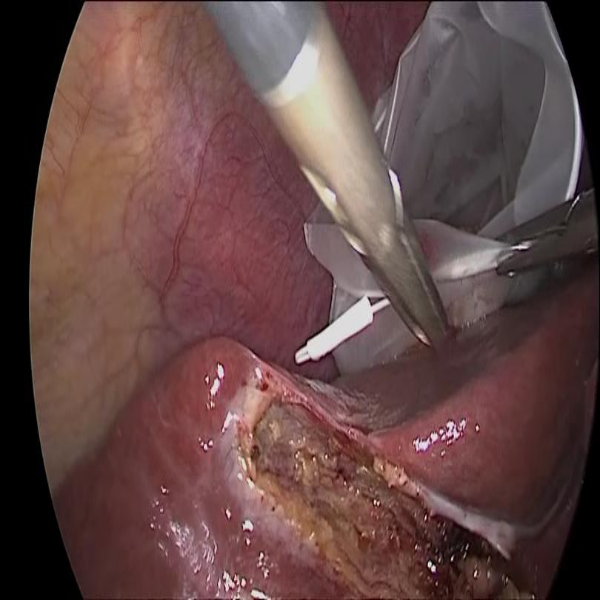

In [ ]:
F.to_pil_image(images[0])

In [7]:
def visualize_image_2(image_t, objects):
  image = np.transpose(image_t.numpy(), (1, 2, 0))
  image = (image * 255).astype(np.uint8).copy()
  bboxes = objects['boxes'].tolist()
  labels = objects['labels']
  labels = labels.tolist()
  for i in range(len(bboxes)):
        bbox = bboxes[i]
        bbox = [int(x) for x in bbox]
        cv2.rectangle(image, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 255, 0), 2)
        cv2.putText(image, str(labels[i]), (bbox[0], bbox[1]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
  plt.imshow(image)
  plt.show()

# i = 4
# visualize_image_2(images[i], labels[i])
# print(labels[i])

In [8]:
# numpy_image = images[0].numpy()

# # Convert the numpy array to a cv2 image
# cv2_image = np.transpose(numpy_image, (1, 2, 0))
# # cv2_image = cv2.cvtColor(cv2_image, cv2.COLOR_BGR2RGB)

# # Display the image using cv2
# plt.imshow(cv2_image)
# plt.show()

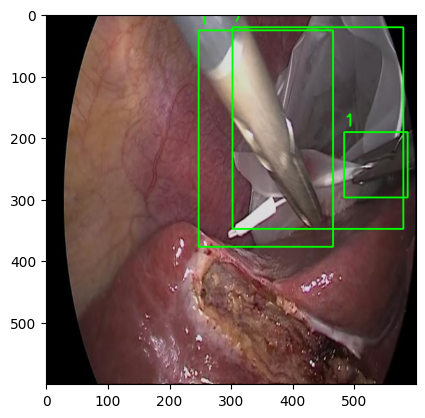

In [ ]:
visualize_image_2(images[0], labels[0])

In [ ]:
labels[0]

{'boxes': tensor([[302.,  21., 579., 348.],
         [483., 191., 586., 297.],
         [247.,  26., 465., 377.]]),
 'labels': tensor([7, 1, 1])}

# Defining the loss functions and the training loop

In [9]:
def calculate_iou_for_labels(true_labels, pred_labels):
    # Initialize a list to store IoU values
    iou_values = []

    # Iterate over the pairs of true and predicted boxes
    for true_box, pred_box in zip(true_labels['boxes'], pred_labels['boxes']):
        # Extract box coordinates and convert to standard list format
        true_box = [b.item() for b in true_box]
        pred_box = [b.item() for b in pred_box]

        # Calculate the coordinates of the intersection rectangle
        xA = max(true_box[0], pred_box[0])
        yA = max(true_box[1], pred_box[1])
        xB = min(true_box[2], pred_box[2])
        yB = min(true_box[3], pred_box[3])

        # Compute the area of intersection rectangle
        interArea = max(0, xB - xA) * max(0, yB - yA)

        # Compute the area of both bounding boxes
        boxAArea = (true_box[2] - true_box[0]) * (true_box[3] - true_box[1])
        boxBArea = (pred_box[2] - pred_box[0]) * (pred_box[3] - pred_box[1])

        # Compute the intersection over union
        iou = interArea / float(boxAArea + boxBArea - interArea)

        # Append the IoU value to the list
        iou_values.append(iou)

    return iou_values

def calculate_iou_for_matching_classes_ordered(true_labels, pred_labels):
    iou_values = []

    # Iterate over each true box and its class
    for true_box, true_class in zip(true_labels['boxes'], true_labels['labels']):
        # Convert true box to standard list format
        true_box = [b.item() for b in true_box]

        best_iou = 0
        best_iou_class = None

        # Iterate over each predicted box and its class
        for pred_box, pred_class in zip(pred_labels['boxes'], pred_labels['labels']):
            # Check if the classes match
            if true_class == pred_class:
                # Convert predicted box to standard list format
                pred_box = [b.item() for b in pred_box]

                # Calculate IoU
                iou = calculate_single_iou(true_box, pred_box)

                # Update best IoU and class if current IoU is higher
                if iou > best_iou:
                    best_iou = iou
                    best_iou_class = pred_class

        if best_iou_class is not None:
            # Append the best IoU value and class to the list
            iou_values.append((best_iou, best_iou_class))

    return iou_values

def calculate_single_iou(boxA, boxB):
    # Calculate the coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # Compute the area of intersection rectangle
    interArea = max(0, xB - xA) * max(0, yB - yA)

    # Compute the area of both bounding boxes
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])

    # Compute the intersection over union
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

# def evaluate_model_on_validation_set(model, dataloader, device):
#     model.eval()
#     iou_scores = []

#     with torch.no_grad():
#         for images, targets in dataloader:
#             images = [image.to(device) for image in images]
#             targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
#             # Process only tensors in targets (like 'boxes' and 'labels'), ignore other data types
#             # targets = [{k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in t.items()} for t in targets]

#             # Get model predictions
#             preds = model(images)

#             # Convert predictions and targets to CPU and to numpy arrays for IoU calculation
#             for target, pred in zip(targets, preds):
#                 true_labels = {'boxes': target['boxes'].cpu(), 'labels': target['labels'].cpu()}
#                 pred_labels = {'boxes': pred['boxes'].cpu(), 'labels': pred['labels'].cpu()}
#                 iou_values = calculate_iou_for_matching_classes_ordered(true_labels, pred_labels)
#                 iou_scores.extend([iou for iou, _ in iou_values])

#     # Calculate average IoU
#     average_iou = np.mean(iou_scores) if iou_scores else 0
#     return average_iou

def evaluate_model_on_validation_set(model, dataloader, device, iou_threshold=0.5):
    model.eval()
    iou_scores = []
    total_true_objects = 0
    correctly_detected_objects = 0

    with torch.no_grad():
        for images, targets in dataloader:
            images = [image.to(device) for image in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            preds = model(images)

            for target, pred in zip(targets, preds):
                true_labels = {'boxes': target['boxes'].cpu(), 'labels': target['labels'].cpu()}
                pred_labels = {'boxes': pred['boxes'].cpu(), 'labels': pred['labels'].cpu()}
                iou_values = calculate_iou_for_matching_classes_ordered(true_labels, pred_labels)

                total_true_objects += len(target['labels'])
                correctly_detected_objects += sum(iou >= iou_threshold for iou, _ in iou_values)

                iou_scores.extend([iou for iou, _ in iou_values])

    average_iou = np.mean(iou_scores) if iou_scores else 0
    accuracy = (correctly_detected_objects / total_true_objects) if total_true_objects else 0
    return average_iou, accuracy

In [10]:
import matplotlib.patches as patches
from torchvision.transforms import ToPILImage
def display_image_with_boxes_true(image, true_labels):
    fig, ax = plt.subplots(1)
    image = image.cpu()
    t = ToPILImage()
    image = t(image)

    # Image with true labels
    ax.imshow(image)
    n_obj_true = len(true_labels['boxes'])
    boxes = true_labels['boxes']
    labels = true_labels['labels']

    for i in range(n_obj_true):
      xmin, ymin, xmax, ymax = boxes[i][0].item(), boxes[i][1].item(), boxes[i][2].item(), boxes[i][3].item()
      rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin,
                               linewidth = 1, edgecolor='r', facecolor='none')
      ax.add_patch(rect)
      plt.text(xmin, ymin-5, labels[i], color='r')
    plt.show()


def display_image_with_boxes_pred(image, pred_labels):

    fig, ax = plt.subplots(1)
    image = image.cpu()
    t = ToPILImage()
    image = t(image)

    # Image with predicted labels
    ax.imshow(image)
    n_obj_true = len(pred_labels['boxes'])
    boxes = pred_labels['boxes']
    labels = pred_labels['labels']
    scores = pred_labels['scores']

    for i in range(n_obj_true):
      if(scores[i]>0.8):
        xmin, ymin, xmax, ymax = boxes[i][0].item(), boxes[i][1].item(), boxes[i][2].item(), boxes[i][3].item()
        rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin,
                                linewidth = 1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        plt.text(xmin, ymin-5, labels[i], color='r')
        print(labels[i]) #del
    plt.show()

In [11]:
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load pre-trained model
model = fasterrcnn_resnet50_fpn(pretrained=True)

# Get the number of input features of the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

num_classes = 8
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 123MB/s]


In [12]:
torch.cuda.is_available()

True

In [13]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
reps = 1
num_epochs = 50
train_losses = np.zeros((reps, num_epochs))
val_IoU = np.zeros((reps, num_epochs))
accuracies = np.zeros((reps, num_epochs))
print("batch size=", batchsize, ", learning rate = ", learnrate, "\n\n")


for rep in range(reps):
  model = fasterrcnn_resnet50_fpn(pretrained=True)
  in_features = model.roi_heads.box_predictor.cls_score.in_features
  num_classes = 8
  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
  model.to(device)
  # choose optimizer
  optimizer = torch.optim.SGD(model.parameters(), lr=learnrate, momentum=0.9, weight_decay=0.00001)
  # optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0005) #sgd original
  for epoch in range(num_epochs):
      print("rep, epoch = ", rep, epoch)
      model.train()
      for images, targets in tqdm(train_dataloader):
          images = list(image.to(device) for image in images)
          targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
          # targets = [{k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in t.items()} for t in targets]


          loss_dict = model(images, targets)
          losses = sum(loss for loss in loss_dict.values())

          optimizer.zero_grad()
          losses.backward()
          optimizer.step()

      train_loss = losses.item()


      model.eval()
      average_iou, accuracy = evaluate_model_on_validation_set(model, val_datalaoder, device)

      train_losses[rep][epoch] = train_loss
      val_IoU[rep][epoch] = average_iou
      accuracies[rep][epoch] = accuracy

      print(f"\nEpoch {epoch} Train Loss: {train_loss:.4f}")
      print(f"Epoch {epoch} Val IoU: {average_iou:.4f}")
      print(f"Epoch {epoch} Val Accuracy: {100*accuracy:.2f}\n")


batch size= 16 , learning rate =  0.002 


rep, epoch =  0 0


100%|██████████| 123/123 [27:15<00:00, 13.30s/it]



Epoch 0 Train Loss: 0.3603
Epoch 0 Val IoU: 0.6793
Epoch 0 Val Accuracy: 91.70

rep, epoch =  0 1


100%|██████████| 123/123 [05:45<00:00,  2.81s/it]



Epoch 1 Train Loss: 0.2414
Epoch 1 Val IoU: 0.7326
Epoch 1 Val Accuracy: 94.94

rep, epoch =  0 2


100%|██████████| 123/123 [05:44<00:00,  2.80s/it]



Epoch 2 Train Loss: 0.2275
Epoch 2 Val IoU: 0.7416
Epoch 2 Val Accuracy: 95.46

rep, epoch =  0 3


100%|██████████| 123/123 [05:43<00:00,  2.79s/it]



Epoch 3 Train Loss: 0.2790
Epoch 3 Val IoU: 0.7532
Epoch 3 Val Accuracy: 95.98

rep, epoch =  0 4


100%|██████████| 123/123 [05:43<00:00,  2.79s/it]



Epoch 4 Train Loss: 0.2007
Epoch 4 Val IoU: 0.7591
Epoch 4 Val Accuracy: 96.50

rep, epoch =  0 5


100%|██████████| 123/123 [05:43<00:00,  2.79s/it]



Epoch 5 Train Loss: 0.1803
Epoch 5 Val IoU: 0.7626
Epoch 5 Val Accuracy: 96.76

rep, epoch =  0 6


100%|██████████| 123/123 [05:43<00:00,  2.79s/it]



Epoch 6 Train Loss: 0.1673
Epoch 6 Val IoU: 0.7653
Epoch 6 Val Accuracy: 97.02

rep, epoch =  0 7


100%|██████████| 123/123 [05:42<00:00,  2.79s/it]



Epoch 7 Train Loss: 0.1540
Epoch 7 Val IoU: 0.7656
Epoch 7 Val Accuracy: 97.02

rep, epoch =  0 8


100%|██████████| 123/123 [05:43<00:00,  2.79s/it]



Epoch 8 Train Loss: 0.1162
Epoch 8 Val IoU: 0.7694
Epoch 8 Val Accuracy: 96.63

rep, epoch =  0 9


100%|██████████| 123/123 [05:43<00:00,  2.79s/it]



Epoch 9 Train Loss: 0.1255
Epoch 9 Val IoU: 0.7681
Epoch 9 Val Accuracy: 96.24

rep, epoch =  0 10


100%|██████████| 123/123 [05:42<00:00,  2.79s/it]


KeyboardInterrupt: 

# Plot training metrics

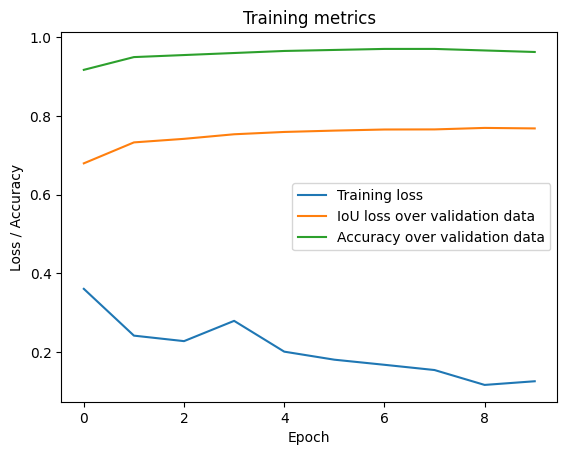

In [39]:
# plt.plot(train_losses[0][:10])
plt.plot(train_losses[0][:10], label = "Training loss")
plt.plot(val_IoU[0][:10], label = "IoU loss over validation data")
plt.plot(accuracies[0][:10], label = "Accuracy over validation data")
plt.legend()
plt.title("Training metrics")
plt.xlabel("Epoch")
plt.ylabel("Loss / Accuracy")
plt.show()

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

# Save model

In [14]:
model_path = "./m2cai16-tool-locations/fastRCNN_train_10epochs.pth"
torch.save(model.state_dict(), model_path)

In [ ]:
model_path = "./m2cai16-tool-locations/fastRCNN_train_8epochs.pth"
model.load_state_dict(torch.load(model_path))

<ipython-input-15-b3150377b2b8>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


<All keys matched successfully>

In [ ]:
torch.cuda.empty_cache()

# Test model on how it looks like - predictions and images

In [15]:
images, targets = next(iter(train_dataloader))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

In [16]:
# at the beginning
model.eval()
pred = model(images)

In [ ]:
targets[0]

{'boxes': tensor([[305., 243., 477., 434.]], device='cuda:0'),
 'labels': tensor([3], device='cuda:0')}

In [41]:
# a function to only output predictions whose scores are > 0.5
def pred_above_thresh(predi, thresh = 0.5):
  indices = predi['scores'] > thresh
  for key in predi.keys():
    predi[key] = predi[key][indices]
  return predi

pred_above_thresh(pred[0])

{'boxes': tensor([[346.4194, 203.4282, 546.5529, 453.1846]], device='cuda:0',
        grad_fn=<IndexBackward0>),
 'labels': tensor([3], device='cuda:0'),
 'scores': tensor([0.9929], device='cuda:0', grad_fn=<IndexBackward0>)}

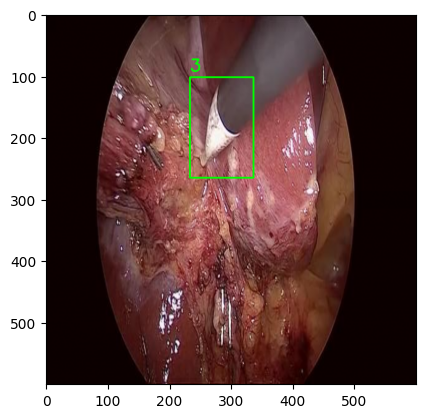

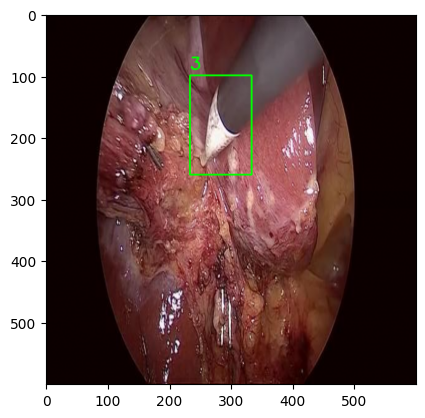

({'boxes': tensor([[233.7832,  99.4940, 333.1238, 260.3141]], device='cuda:0',
         grad_fn=<IndexBackward0>),
  'labels': tensor([3], device='cuda:0'),
  'scores': tensor([0.9981], device='cuda:0', grad_fn=<IndexBackward0>)},
 {'boxes': tensor([[233., 102., 336., 265.]], device='cuda:0'),
  'labels': tensor([3], device='cuda:0')})

In [45]:
i = 3
visualize_image_2(images[i].cpu(), targets[i])
visualize_image_2(images[i].cpu(), pred_above_thresh(pred[i], 0.85))
pred[i], targets[i]

# Test data metrics

In [54]:
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score

def test_model(model, test_dataloader, device):
    """
    Tests the model on the test dataloader and outputs relevant metrics.

    Args:
        model: The trained object detection model.
        test_dataloader: The test dataloader.
        device: The device to run the model on (e.g., 'cuda' or 'cpu').
    """

    model.eval()
    all_true_labels = []
    all_pred_labels = []

    all_true_bboxes = []
    all_pred_bboxes = []
    i = 0

    with torch.no_grad():
        for images, targets in tqdm(test_dataloader):
            images = [image.to(device) for image in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            preds = model(images)

            for target, pred in zip(targets, preds):
                # Filter predictions with confidence threshold (adjust as needed)
                filtered_pred_indices = pred['scores'] > 0.5
                pred_labels = pred['labels'][filtered_pred_indices].cpu().numpy()
                true_labels = target['labels'].cpu().numpy()

                pred_bboxes = pred['boxes'][filtered_pred_indices].cpu().numpy()
                true_bboxes = target['boxes'].cpu().numpy()

                all_true_labels.extend([true_labels])
                all_pred_labels.extend([pred_labels])

                all_true_bboxes.extend([true_bboxes])
                all_pred_bboxes.extend([pred_bboxes])

    # Calculate metrics
    # accuracy = accuracy_score(all_true_labels, all_pred_labels)
    # conf_matrix = confusion_matrix(all_true_labels, all_pred_labels)

    # print(f"Test Accuracy: {accuracy:.4f}")
    # print("Confusion Matrix:")
    # print(conf_matrix)

    return(all_true_labels, all_pred_labels, all_true_bboxes, all_pred_bboxes)

    # You can add more metrics here, such as precision, recall, F1-score, etc.

# Example usage
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
all_true_labels, all_pred_labels, all_true_bboxes, all_pred_bboxes = test_model(model, test_dataloader, device)

100%|██████████| 281/281 [00:29<00:00,  9.42it/s]


In [61]:
len(all_true_labels), len(all_pred_labels)

(281, 281)

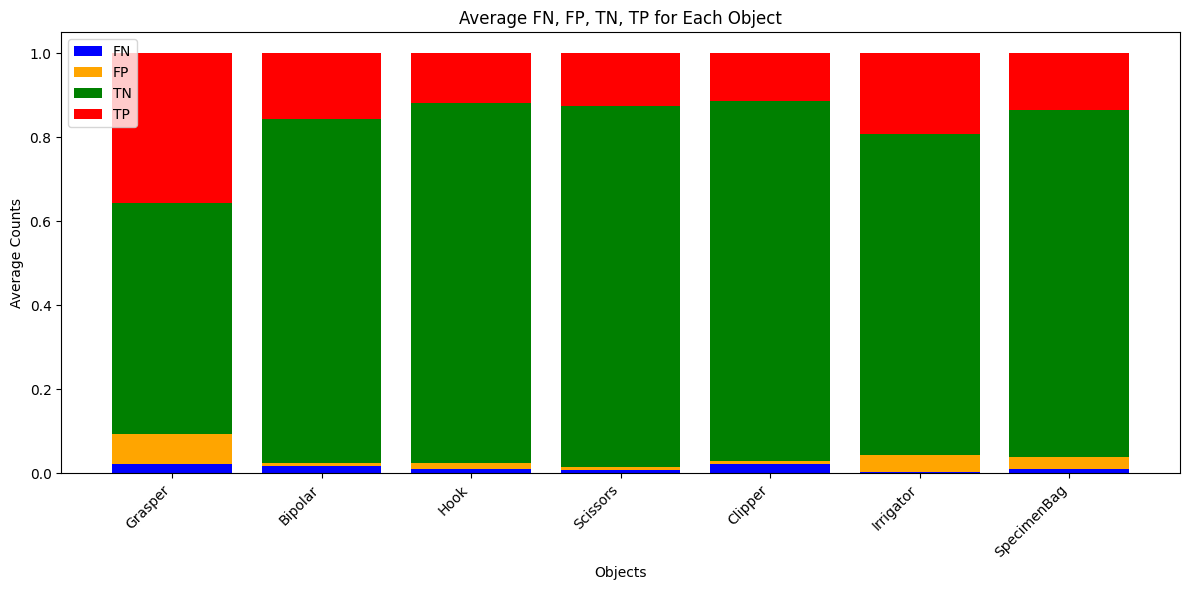

In [68]:
import numpy as np
import matplotlib.pyplot as plt

def plot_average_metrics(all_true_labels, all_pred_labels, class_names):


    num_objects = len(class_names)  # Assuming class_names represents all objects
    fn_counts = np.zeros(num_objects)
    fp_counts = np.zeros(num_objects)
    tn_counts = np.zeros(num_objects)
    tp_counts = np.zeros(num_objects)

    for true_labels, pred_labels in zip(all_true_labels, all_pred_labels):
        for obj_index in range(num_objects):
            # Check if the object is present in true and predicted labels
            true_present = obj_index + 1 in true_labels  # +1 because labels start from 1
            pred_present = obj_index + 1 in pred_labels

            if true_present and pred_present:
                tp_counts[obj_index] += 1
            elif true_present and not pred_present:
                fn_counts[obj_index] += 1
            elif not true_present and pred_present:
                fp_counts[obj_index] += 1
            else:
                tn_counts[obj_index] += 1

    # Calculate averages
    total_samples = len(all_true_labels)
    fn_avg = fn_counts / total_samples
    fp_avg = fp_counts / total_samples
    tn_avg = tn_counts / total_samples
    tp_avg = tp_counts / total_samples

    # Plot the averages
    plt.figure(figsize=(12, 6))
    plt.bar(class_names, fn_avg, label='FN', color='blue')
    plt.bar(class_names, fp_avg, label='FP', color='orange', bottom=fn_avg)
    plt.bar(class_names, tn_avg, label='TN', color='green', bottom=fn_avg + fp_avg)
    plt.bar(class_names, tp_avg, label='TP', color='red', bottom=fn_avg + fp_avg + tn_avg)

    plt.xlabel('Objects')
    plt.ylabel('Average Counts')
    plt.title('Average FN, FP, TN, TP for Each Object')
    plt.legend()
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
    plt.tight_layout()
    plt.show()

# Example usage (assuming you have all_true_labels, all_pred_labels, and your_label_map):
class_names = list(your_label_map.keys())  # Get class names from your_label_map
plot_average_metrics(all_true_labels, all_pred_labels, class_names)

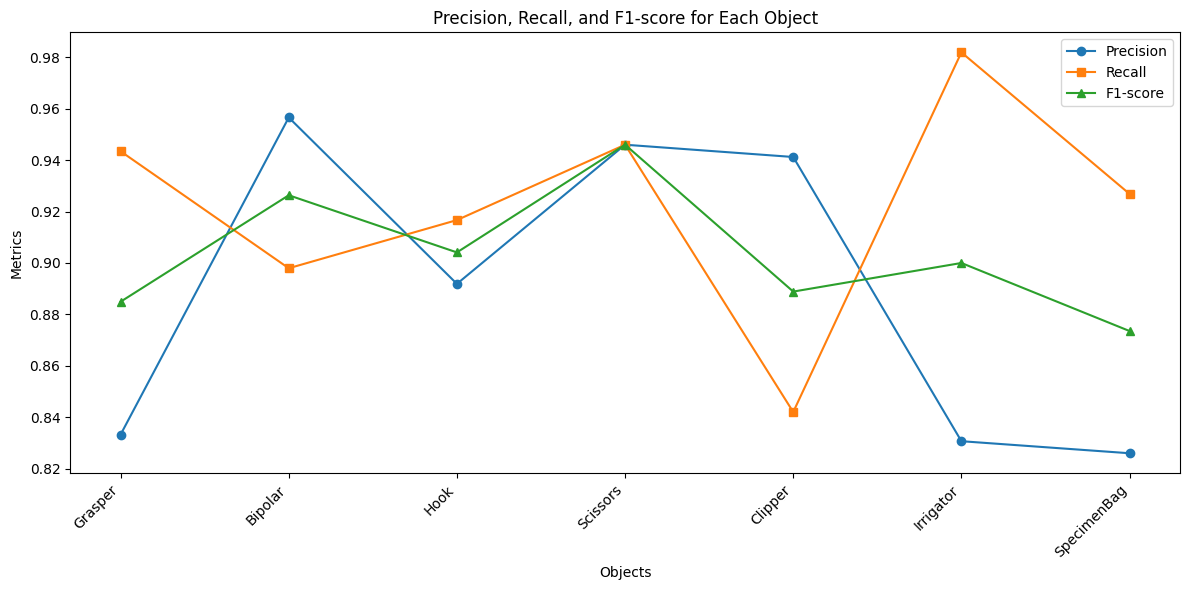

In [69]:
import numpy as np
import matplotlib.pyplot as plt

def plot_precision_recall_f1(all_true_labels, all_pred_labels, class_names):

    num_objects = len(class_names)
    precision = np.zeros(num_objects)
    recall = np.zeros(num_objects)
    f1_score = np.zeros(num_objects)

    for obj_index in range(num_objects):
        tp = 0
        fp = 0
        fn = 0
        #tn = 0 #not needed for precision recall and f1 score

        for true_labels, pred_labels in zip(all_true_labels, all_pred_labels):
            # Check if the object is present in true and predicted labels
            true_present = obj_index + 1 in true_labels  # +1 because labels start from 1
            pred_present = obj_index + 1 in pred_labels

            if true_present and pred_present:
                tp += 1
            elif true_present and not pred_present:
                fn += 1
            elif not true_present and pred_present:
                fp += 1
            #else:
            #   tn += 1

        # Calculate Precision, Recall, and F1-score for the object
        if tp + fp > 0:  # Avoid division by zero
            precision[obj_index] = tp / (tp + fp)
        if tp + fn > 0:  # Avoid division by zero
            recall[obj_index] = tp / (tp + fn)
        if precision[obj_index] + recall[obj_index] > 0:  # Avoid division by zero
            f1_score[obj_index] = 2 * (precision[obj_index] * recall[obj_index]) / (precision[obj_index] + recall[obj_index])

    # Plot the metrics
    plt.figure(figsize=(12, 6))
    plt.plot(class_names, precision, label='Precision', marker='o')
    plt.plot(class_names, recall, label='Recall', marker='s')
    plt.plot(class_names, f1_score, label='F1-score', marker='^')

    plt.xlabel('Objects')
    plt.ylabel('Metrics')
    plt.title('Precision, Recall, and F1-score for Each Object')
    plt.legend()
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
    plt.tight_layout()
    plt.show()

# Example usage (assuming you have all_true_labels, all_pred_labels, and your_label_map):
class_names = list(your_label_map.keys())  # Get class names from your_label_map
plot_precision_recall_f1(all_true_labels, all_pred_labels, class_names)

AttributeError: module 'torch.cuda' has no attribute 'clear_cache'

In [ ]:
targets

[{'boxes': tensor([[319., 168., 509., 523.],
          [253., 426., 415., 586.]], device='cuda:0'),
  'labels': tensor([7, 1], device='cuda:0')},
 {'boxes': tensor([[364., 353., 510., 469.]], device='cuda:0'),
  'labels': tensor([2], device='cuda:0')},
 {'boxes': tensor([[253., 332., 359., 497.],
          [141.,  50., 276., 210.],
          [286.,  10., 388., 145.]], device='cuda:0'),
  'labels': tensor([4, 1, 1], device='cuda:0')},
 {'boxes': tensor([[415., 242., 511., 468.]], device='cuda:0'),
  'labels': tensor([5], device='cuda:0')},
 {'boxes': tensor([[127.,  51., 223., 310.],
          [349., 133., 500., 373.]], device='cuda:0'),
  'labels': tensor([2, 1], device='cuda:0')},
 {'boxes': tensor([[219., 238., 287., 387.]], device='cuda:0'),
  'labels': tensor([3], device='cuda:0')},
 {'boxes': tensor([[241., 141., 317., 255.]], device='cuda:0'),
  'labels': tensor([1], device='cuda:0')},
 {'boxes': tensor([[358., 263., 498., 435.],
          [121., 164., 197., 279.]], device='cuda:

In [ ]:
# at the beginning of the simulation
model.eval()
pred = model(images.to(device))
visualize_image_2(images[0], pred[0])

NameError: name 'device' is not defined

# Trying out detection transformer

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader, Dataset
from transformers import DetrImageProcessor, DetrForObjectDetection
from torchvision.transforms import functional as F
from torch.nn import functional as F

In [ ]:
processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50", revision="no_timm")
model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50", revision="no_timm")



preprocessor_config.json:   0%|          | 0.00/401 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/6.60k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/167M [00:00<?, ?B/s]

In [ ]:
model

DetrForObjectDetection(
  (model): DetrModel(
    (backbone): DetrConvModel(
      (conv_encoder): DetrConvEncoder(
        (model): ResNetBackbone(
          (embedder): ResNetEmbeddings(
            (embedder): ResNetConvLayer(
              (convolution): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
              (normalization): DetrFrozenBatchNorm2d()
              (activation): ReLU()
            )
            (pooler): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          )
          (encoder): ResNetEncoder(
            (stages): ModuleList(
              (0): ResNetStage(
                (layers): Sequential(
                  (0): ResNetBottleNeckLayer(
                    (shortcut): ResNetShortCut(
                      (convolution): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
                      (normalization): DetrFrozenBatchNorm2d()
                    )
                    (layer): Seq

In [ ]:
inputs = processor(images=images, return_tensors="pt", do_rescale = False)


In [ ]:
model.config.num_labels = 7
model.class_labels_classifier = nn.Linear(in_features = 256, out_features = 8)

In [ ]:
inputs = inputs.to("cuda")
model = model.to("cuda")

In [ ]:
outputs = model(**inputs)

In [ ]:
images.shape

torch.Size([16, 3, 600, 600])

In [ ]:
outputs.pred_boxes.shape

torch.Size([16, 100, 4])

In [ ]:
t = torchvision.transforms.ToPILImage()

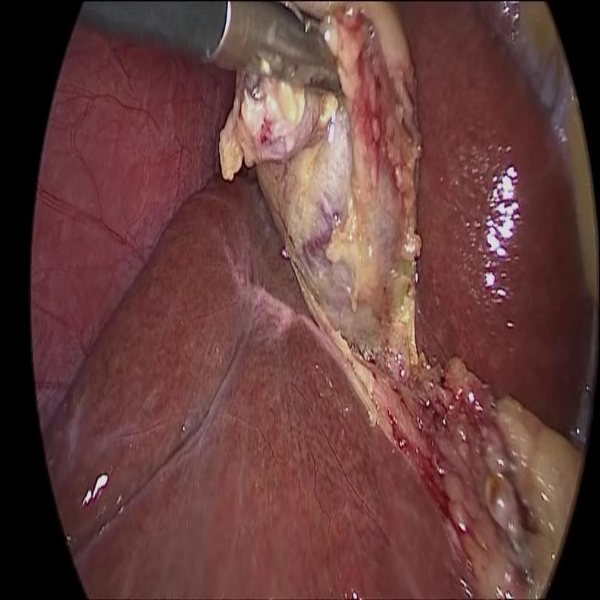

In [ ]:
image =t( images[0])
from PIL import Image, ImageDraw, ImageFont
image

In [ ]:
logits = outputs.logits
boxes = outputs.pred_boxes
logits = logits.to("cpu")
boxes = boxes.to("cpu")
confidence_threshold = 0.35
keep = logits.softmax(-1).max(-1).values > confidence_threshold

# Get the predicted boxes and labels above the threshold
boxes = boxes[keep]
labels = logits.argmax(-1)[keep]

# Convert bounding boxes to image coordinates
image_width, image_height = image.size
boxes = boxes * torch.tensor([image_width, image_height, image_width, image_height], dtype=torch.float32)


In [ ]:
boxes[0][1] = 592
boxes[0][3] = 298

In [ ]:
# boxes = boxes.tolist()
# labels = labels.tolist()

boxes = [[100, 200, 300, 400],
         [250, 350, 450, 550]]
labels = [1, 2]

1
2


TypeError: Image data of dtype object cannot be converted to float

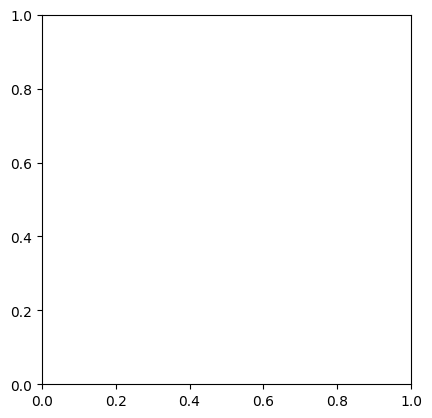

In [ ]:
draw = ImageDraw.Draw(image)
for box, label in zip(boxes, labels):
    print(label)
    # Draw the bounding box
    xmin, ymin, xmax, ymax = box
    draw.rectangle(box, outline="red", width=3)

    # Draw the label (optional)
    label_text = f"Class {label}"
    draw.text((xmin, ymin), label_text, fill="red")  # You can use a font here if desired

# Display the image with bounding boxes
plt.imshow(draw)
plt.show()

TypeError: Image data of dtype object cannot be converted to float

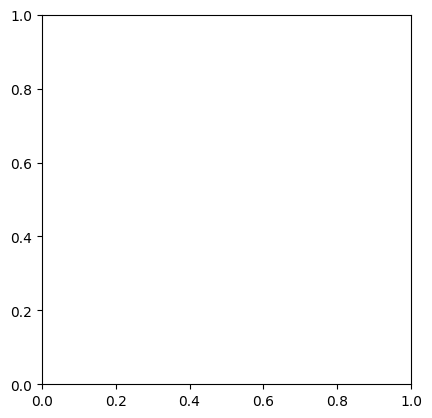

In [ ]:
plt.imshow(draw)

In [ ]:
import torch
import torch.nn as nn
from transformers import DetrModel, DetrConfig, DetrFeatureExtractor

In [ ]:
# Configuration
config = DetrConfig.from_pretrained("facebook/detr-resnet-50")
model = DetrModel(config)

config.json:   0%|          | 0.00/4.59k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

In [ ]:
# Custom head for object detection (boxes and labels)
class DetectionTransformer(nn.Module):
    def __init__(self, detr_model, num_classes):
        super().__init__()
        self.detr = detr_model
        hidden_dim = self.detr.config.d_model

        # Box prediction head
        self.box_predictor = nn.Linear(hidden_dim, 4)  # (x_min, y_min, x_max, y_max)

        # Label prediction head
        self.label_predictor = nn.Linear(hidden_dim, num_classes)

    def forward(self, pixel_values):
        # Pass through the DETR model
        outputs = self.detr(pixel_values=pixel_values)

        # Final hidden states
        hidden_states = outputs.last_hidden_state

        # Predict boxes and labels
        predicted_boxes = self.box_predictor(hidden_states)
        predicted_labels = self.label_predictor(hidden_states)

        return {"boxes": predicted_boxes, "labels": predicted_labels}

In [ ]:
# Define the custom DETR model
num_classes = 7  # For example, 91 classes in COCO dataset
custom_detr = DetectionTransformer(model, num_classes)

In [ ]:
# Preprocessing
feature_extractor = DetrFeatureExtractor.from_pretrained("facebook/detr-resnet-50")

# Input image batch (16 images of size 600x600x3)
batch_size = 16
image_size = (600, 600)
images = [torch.rand(3, *image_size) for _ in range(batch_size)]

/usr/local/lib/python3.10/dist-packages/transformers/models/detr/feature_extraction_detr.py:38: FutureWarning: The class DetrFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use DetrImageProcessor instead.
  warnings.warn(


In [ ]:
# Preprocess the images
inputs = feature_extractor(images=images, return_tensors="pt")

# Forward pass
outputs = custom_detr(inputs["pixel_values"])

It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.


KeyboardInterrupt: 

In [ ]:
inputs["pixel_values"][0].shape

torch.Size([3, 800, 800])

In [ ]:
len(outputs['boxes'][0])

100

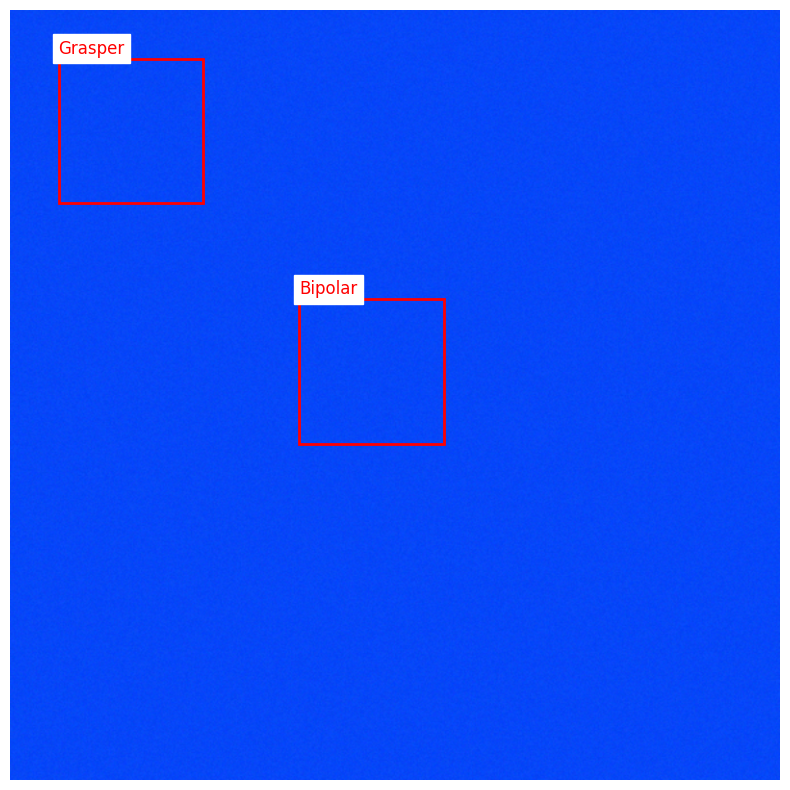

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from transformers import DetrFeatureExtractor
import torch

# Pre-trained DETR feature extractor
feature_extractor = DetrFeatureExtractor.from_pretrained("facebook/detr-resnet-50")

def visualize_predictions(image, predictions, class_names=None):
    """
    Visualizes an image with bounding boxes and labels.

    Args:
        image (torch.Tensor): The input image (3 x H x W).
        predictions (dict): Contains "boxes" (list of [x_min, y_min, x_max, y_max])
                            and "labels" (list of label indices).
        class_names (list, optional): List of class names for labels. Default: None.
    """
    # Convert image from Tensor to NumPy (H x W x 3) and normalize for visualization
    image = image.permute(1, 2, 0).numpy()
    image = (image - image.min()) / (image.max() - image.min())  # Normalize to [0, 1]

    # Create the plot
    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(image)

    # Draw each bounding box and label
    for box, label in zip(predictions["boxes"], predictions["labels"]):
        x_min, y_min, x_max, y_max = box

        # Draw the bounding box
        rect = patches.Rectangle(
            (x_min, y_min), x_max - x_min, y_max - y_min,
            linewidth=2, edgecolor='r', facecolor='none'
        )
        ax.add_patch(rect)

        # Add label text
        if class_names:
            label_text = class_names[label]
        else:
            label_text = f"Class {label}"

        ax.text(
            x_min, y_min - 5, label_text,
            color='red', fontsize=12, backgroundcolor='white'
        )

    plt.axis("off")
    plt.show()



    # Visualize predictions
visualize_predictions(256*inputs["pixel_values"][0], example_predictions, class_names=coco_class_names)


In [ ]:


# Post-processing function
def process_predictions(predictions, threshold=0.5):
    batch_size, num_queries, _ = predictions["boxes"].shape
    results = []
    for i in range(batch_size):
        boxes = predictions["boxes"][i]
        scores = torch.softmax(predictions["labels"][i], dim=-1)
        max_scores, labels = scores.max(dim=-1)

        # Filter predictions based on confidence threshold
        selected = max_scores > threshold
        filtered_boxes = boxes[selected]
        filtered_labels = labels[selected]

        # Convert to dictionary format
        results.append(
            {
                "boxes": filtered_boxes.tolist(),
                "labels": filtered_labels.tolist(),
            }
        )
    return results

# Example post-processing
detections = process_predictions(outputs)
print(detections)
